In [34]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import MiniBatchKMeans

In [547]:
folder = 'InSample1/4/'

files = os.listdir(folder)
pics = {}
kpics = {}

PERCENTILE_CUTOFF = 50


for filee in files:
    image = cv2.imread(folder + "/" + filee)
    image = cv2.resize(image,None,fx=0.25,fy=0.25)

    pics[filee.split(".")[0]] = image
    kpics[filee.split(".")[0]] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("All Images Read.")

All Images Read.


In [548]:
kp = {}
des = {}

nkp = {}
ndes = {}

for key, value in kpics.items():
    print("Extracting all features for Image {}".format(key))
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(kpics[key], None)
    kp[key] = keypoints
    des[key] = descriptors
    
    kp_coordinates = np.array([list(i.pt) for i in keypoints])

    new_descriptors = np.block([descriptors, kp_coordinates])

    print("Finding unique features out of total {} keypoints from Image {}".format(len(kp[key]), key))
    kmeans = MiniBatchKMeans(n_clusters=len(kp[key]) / 100, random_state=0, batch_size = len(kp[key]) / 100).fit(new_descriptors)

    clusters = kmeans.labels_
    distances = np.sqrt(np.sum((new_descriptors - kmeans.cluster_centers_[clusters]) ** 2, axis = 1))

    percentile = np.percentile(distances, PERCENTILE_CUTOFF)
    ndes[key] = des[key][distances > percentile]
    nkp[key] = list(np.array(kp[key])[distances > percentile])
    
des = ndes
kp = nkp

print("Finding unique features done.")

Extracting all features for Image 1
Finding unique features out of total 2674 keypoints from Image 1
Extracting all features for Image 2
Finding unique features out of total 1315 keypoints from Image 2
Extracting all features for Image 5
Finding unique features out of total 2078 keypoints from Image 5
Extracting all features for Image 4
Finding unique features out of total 1532 keypoints from Image 4
Finding unique features done.


In [549]:
print("Feature matching among all pairs of Images starting.")

matches_dict = {}
total_matches = []


for i in kpics.keys():
    matches_dict[i] = {}

    for j in kpics.keys():
        if i != j:
            key1 = i
            key2 = j
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50)   # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)
            matches = flann.knnMatch(des[key1],des[key2],k=2)
            matchesMask = [[0,0] for _ in range(len(matches))]
            good_matches = []
            for m,n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
            matches = good_matches        
            matches = sorted(matches, key = lambda x:x.distance)
            
            if len(matches) > 200:
                matches = matches[:200]
            matches_dict[i][j] = matches
            total_matches += matches
            
            print("Between {} and {}, number of good matches: {}".format(i, j, len(matches)))

average_matches_per_pair = len(total_matches) / (len(matches_dict))

match_distances = [match.distance for match in total_matches]

print(100 / (len(kpics) - 1))

percentile_matches = np.percentile(match_distances, 100 / (len(kpics) - 1))

print("Feature Matching Done For all Images, Distance to beat: {}".format(percentile_matches))

Feature matching among all pairs of Images starting.
Between 1 and 2, number of good matches: 71
Between 1 and 5, number of good matches: 5
Between 1 and 4, number of good matches: 55
Between 2 and 1, number of good matches: 70
Between 2 and 5, number of good matches: 25
Between 2 and 4, number of good matches: 57
Between 5 and 1, number of good matches: 6
Between 5 and 2, number of good matches: 28
Between 5 and 4, number of good matches: 65
Between 4 and 1, number of good matches: 46
Between 4 and 2, number of good matches: 56
Between 4 and 5, number of good matches: 59
33
Feature Matching Done For all Images, Distance to beat: 122.433654785


In [550]:
average_matches_per_pair

135

In [551]:
MIN_MATCH_COUNT = 3

print(MIN_MATCH_COUNT)
best_match = {}
best_match_count = {}
good_matches_dict = {}

for key in kpics.keys():
    best_match_count[key] = 0

order = {}
for i in kpics.keys():
    good_matches_dict[i] = {} 
    for j in kpics.keys():
        if i != j:
            good_matches_dict[i][j] = []
            for match in matches_dict[i][j]:
                if match.distance < percentile_matches:
                    good_matches_dict[i][j].append(match)
             
            good_matches = good_matches_dict[i][j]
            print("Between {} and {}".format(i, j))
            print(len(good_matches))
            
            if len(good_matches) >= MIN_MATCH_COUNT:
                img1, img2, kp1, kp2 = kpics[i], kpics[j], kp[i], kp[j]
                cimg1, cimg2 = pics[i], pics[j]
                
                img1_pts = np.float32([ kp1[m.queryIdx].pt for m in matches_dict[i][j]]).reshape(-1,1,2)
                img2_pts = np.float32([ kp2[m.trainIdx].pt for m in matches_dict[i][j]]).reshape(-1,1,2)                
                H1, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC,8, maxIters=2000)

                if type(H1) != type(None) and H1[0][2] > 0:
                    H2, mask = cv2.findHomography(img2_pts, img1_pts, cv2.RANSAC,8, maxIters=2000)

                    H2_inverse = np.linalg.inv(H2)

                    H = (H1 + H2_inverse) / 2.
                    H = H1
                    
                    if len(good_matches) > best_match_count[j]:
                        best_match[j] = (i, H)
                        best_match_count[j] = len(good_matches)
                        order[j] = i

                    
# print(best_match)
# print(order)
# print(bm)

3
Between 1 and 2
29
Between 1 and 5
1
Between 1 and 4
11
Between 2 and 1
28
Between 2 and 5
7
Between 2 and 4
15
Between 5 and 1
1
Between 5 and 2
7
Between 5 and 4
26
Between 4 and 1
11
Between 4 and 2
15
Between 4 and 5
27


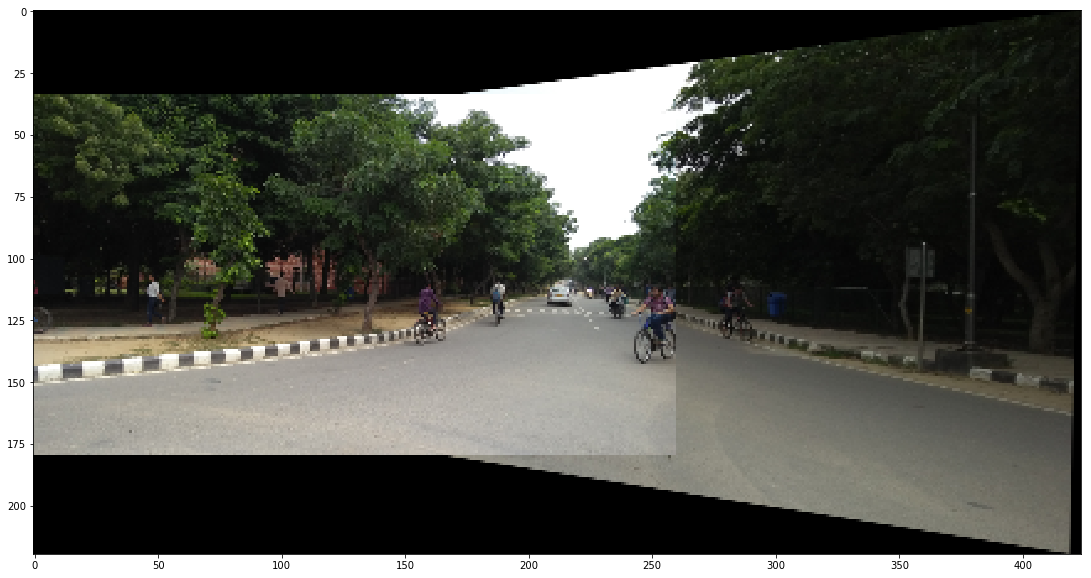

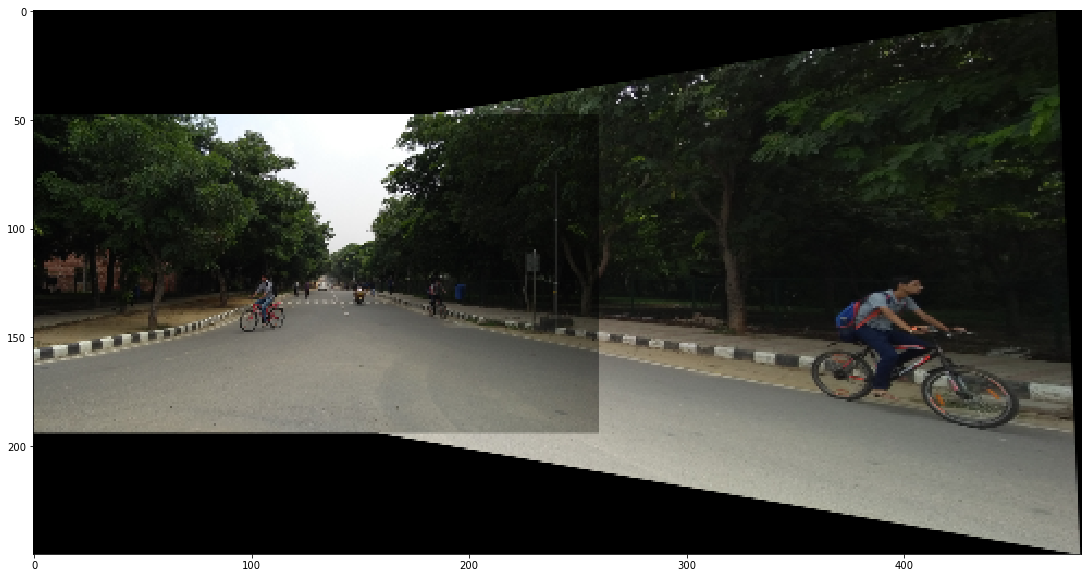

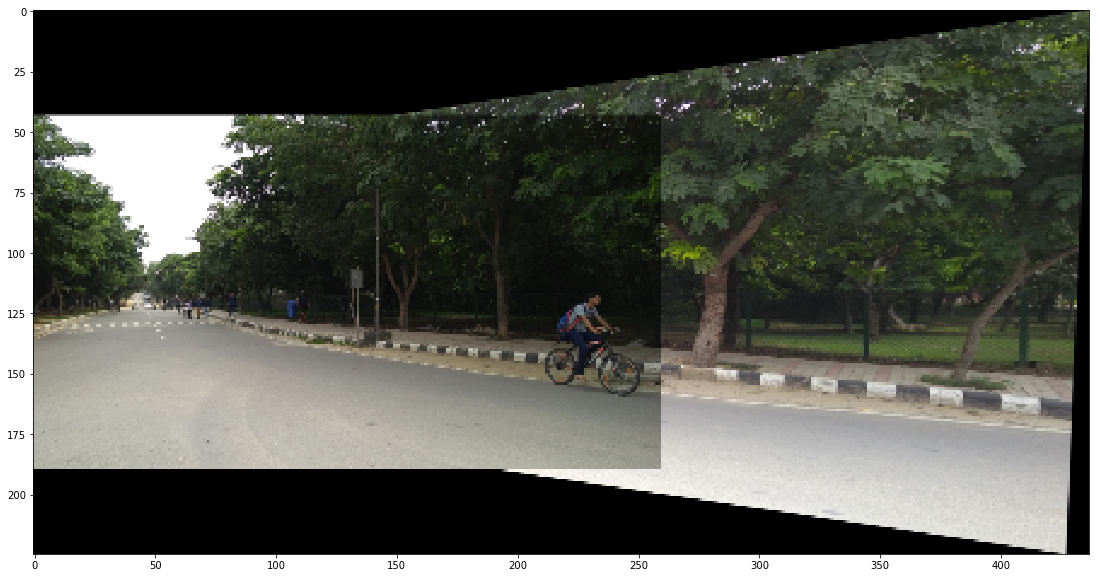

In [552]:
for key in best_match.keys():
    match, H = best_match[key]
    
    img1, img2 = pics[match], pics[key]
    
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)


    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    t = [-xmin,-ymin]

    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2
    
    result = cv2.resize(result,None,fx=0.25,fy=0.25)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                    
    plt.figure(figsize=(20, 10))
    plt.imshow(result)
    plt.show()

In [553]:
for key in order.keys():
    if key not in order.values():
        starting_frame = key
        
reverse_order = {}
for key in order.keys():
    value = order[key]
    reverse_order[value] = key
    
# print(reverse_order)

key = starting_frame
print(key)
num = 0
order_list = [key]

bm = {}

bm[key] = np.eye(3)

while key in best_match.keys():
    match, H = best_match[key]
    key = match
    order_list.append(key)
    

print(order_list)

middle = len(order_list) / 2

H_dict = {}
H_dict[order_list[middle]] = np.eye(3)

for i in range(middle):
    _, H_i = best_match[order_list[i]]
#     print(order_list[i], " ", H_i)
    for j in range(i + 1, middle):
        _, H_j = best_match[order_list[j]]
#         print(order_list[j], " ", H_j)

        H_i = np.dot(H_i, H_j)
#         print("\n")
#         print(H_i)
    H_i = np.linalg.inv(H_i)
    H_dict[order_list[i]] = H_i

    
for i in order_list[middle:]:
    if i in best_match.keys():
#         print(i)
        j, H = best_match[i]
        H_dict[j] = np.dot(H_dict[i], H)
    


1
['1', '2', '4', '5']


In [554]:
x, y = 0., 0.

i = 3

In [555]:
np.dot(H_dict[order_list[i]], [x, y, 1])/np.dot(H_dict[order_list[i]], [x, y, 1])[2]

array([372.15693871,  33.28099331,   1.        ])

In [556]:
cv2.perspectiveTransform(np.array([[[x, y]]]), H_dict[order_list[i]])

array([[[372.15693871,  33.28099331]]])

In [557]:
print(pts1)

[[[   0.    0.]]

 [[   0.  585.]]

 [[1040.  585.]]

 [[1040.    0.]]]


5
(-6450, -1898, 1749, 2085)
(8199, 3983)


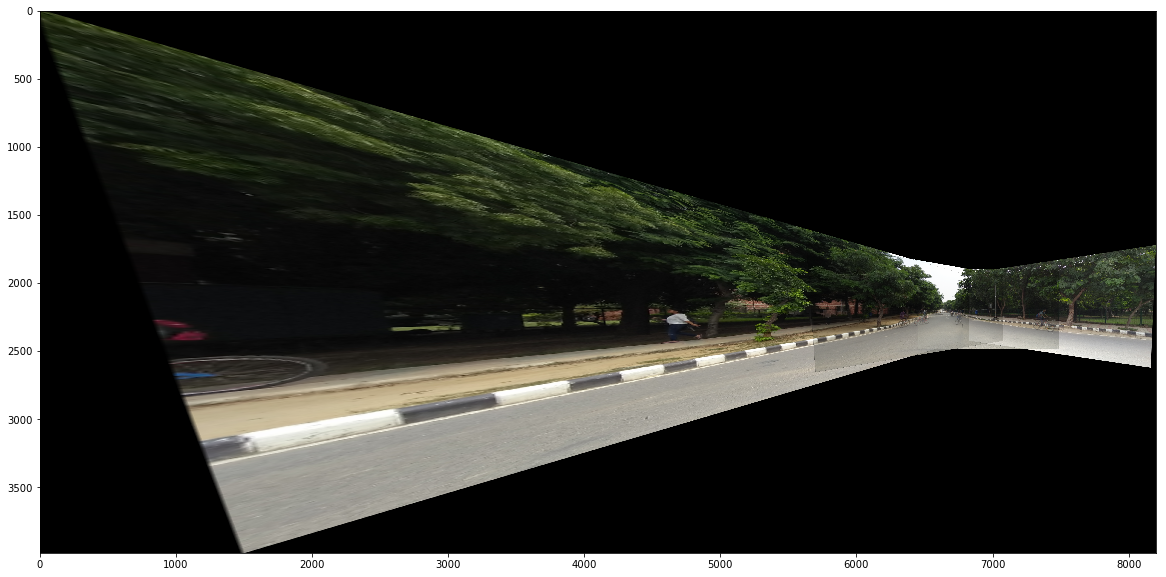

In [558]:
last = -1
first = 0

img2 = pics[order_list[last]]
img1 = pics[order_list[first]]

print(order_list[last])

h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]

pts1 = np.float32([[0,0],[0,h1],[w1,0],[w1,h1]]).reshape(-1, 1, 2)
pts2 = np.float32([[0,0],[0,h2],[w2,0],[w2,h2]]).reshape(-1, 1, 2)


pts2_t = cv2.perspectiveTransform(pts2, H_dict[order_list[last]])
pts1_t = cv2.perspectiveTransform(pts1, H_dict[order_list[first]])

pts = np.concatenate((pts1_t, pts2_t), axis=0)


[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
print(xmin, ymin, xmax, ymax)

Ht = np.reshape(np.array([1, 0, -xmin, 0, 1, -ymin, 0, 0, 1]), (3, 3))

dsize = (xmax - xmin, ymax - ymin)
print(dsize)
result2 = cv2.warpPerspective(img2, Ht.dot(H_dict[order_list[last]]), dsize)
present2 = (result2 != 0).astype(np.int8)

result1 = cv2.warpPerspective(img1, Ht.dot(H_dict[order_list[first]]), dsize)
present1 = (result1 != 0).astype(np.int8)

result = result1 * present1 + result2 * present2
present = present1 + present2

for i in order_list[1:last]:
    img3 = pics[i]
    result3 = cv2.warpPerspective(img3, Ht.dot(H_dict[i]), dsize)
    present3 = (result3 != 0).astype(np.int8)
    
    result = result + result3
    present = present + present3
    
result = result / (present + 0.0001)

result = result.astype(np.uint8)
                  
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                    
plt.figure(figsize=(20, 10))
plt.imshow(result)
plt.show()